# Study of US Visitors 
### Data Engineering Capstone Project

#### Project Summary
The objective of this project is to build a star schema for exploring US Visitors data that is enriched by
additional data sets such as demographics of US Cities and US Airports. The star schema representation
will allow us to develop many queries to gain insights. 

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import seaborn as sns
import logging

# Prep logger
logger = logging.getLogger(__name__)

In [2]:
# Utilities
def check_NaN_Values_DF(df,     # type, Pandas DataFrame
                        cnames  # type, List of String, Column Names
                       ):
    if df is None:
        raise ValueError()
    #assert (cnames != None), "Invalid argument!"
    
    print("%22s %6s %8s" % ('Column Name','Count','Percentage'))
    for c in cnames:
        c_sum = df[c].isnull().sum()
        c_percentage = 100.0*c_sum/len(df)
        print("%22s %6d %8.2f" % (c,c_sum,c_percentage))
    print("Number of total records is %d.\n" % len(df))    


### Step 1: Scope the Project and Gather Data

#### Scope 

The project will use the following data sets to build a star schema based solution for generating reports;
 1. US Visitors Data Set [1]
 1. Airport Codes Data [3]
 1. US Cities Demographics [4]
 1. Global Land Temperatures By City [5]

The solution will allow us to answer questions like the followings;
 1. For each month, what are the main reason (business, tourism, education) of visits? 
 1. Which states are top-10 destinations for Tourists? Is there a difference between months? 
 1. Which states are top-10 destinations for Business travelers? Is there a difference between months? Is there a trend?
 1. What is the relation between month, age of visitor, and top destinations?
 
The project will use the followings;
 1. Spark
 2. Matplotlib for visualization
 3. Parquet Files for star schema
 
#### Describe and Gather Data 
This project uses the following data sets;

 - <b>US Visitors Data Set</b> [1] is from  https://travel.trade.gov/research/programs/i94/description.asp. It contains -94 arrivals data. <br><br>
 - <b>Airport Codes Data</b> [3] set is from Airport Codes, https://datahub.io/core/airport-codes#readme. The dataset contains the list of airports with name, type, location, and gps location attributes. <br><br>
 - <b>US Cities Demographics</b> [4] data set is from https://public.opendatasoft.com/explore/dataset/us-cities-demographics/table/. The dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. The US Census Bureau's 2015 American Community Survey produced the data.<br><br>
 - <b>Global Land Temperatures By City</b> [5] dataset is from https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data.
   The original data came from the Berkeley Earth, which is affiliated with Lawrence Berkeley National Laboratory. 

#### US Visitors Data Set [1]

In [3]:
# Read in the data here
df = pd.read_csv('immigration_data_sample.csv')

In [4]:
df.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [5]:
df = df.astype({'i94yr': 'int32','i94mon': 'int32','i94mode': 'int32','biryear': 'int32','i94cit': 'int32','i94res': 'int32','cicid': 'int64','i94visa': 'int32','i94bir': 'int32','admnum': 'int64' })
df.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316,2016,4,209,209,HHW,20566.0,1,HI,...,NaN,M,1955,07202016,F,NaN,JL,56582674633,00782,WT
1,2171295,4422636,2016,4,582,582,MCA,20567.0,1,TX,...,NaN,M,1990,10222016,M,NaN,*GA,94361995930,XBLNG,B2
2,589494,1195600,2016,4,148,112,OGG,20551.0,1,FL,...,NaN,M,1940,07052016,M,NaN,LH,55780468433,00464,WT
3,2631158,5291768,2016,4,297,297,LOS,20572.0,1,CA,...,NaN,M,1991,10272016,M,NaN,QR,94789696030,00739,B2
4,3032257,985523,2016,4,111,111,CHM,20550.0,3,NY,...,NaN,M,1997,07042016,F,NaN,NaN,42322572633,LAND,WT


Let's look at column names.

In [6]:
df.columns

Index(['Unnamed: 0', 'cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port',
       'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa',
       'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd',
       'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum',
       'airline', 'admnum', 'fltno', 'visatype'],
      dtype='object')

Let's check the columns with NaN value

In [8]:
check_NaN_Values_DF(df,df.columns)

           Column Name  Count Percentage
            Unnamed: 0      0     0.00
                 cicid      0     0.00
                 i94yr      0     0.00
                i94mon      0     0.00
                i94cit      0     0.00
                i94res      0     0.00
               i94port      0     0.00
               arrdate      0     0.00
               i94mode      0     0.00
               i94addr     59     5.90
               depdate     49     4.90
                i94bir      0     0.00
               i94visa      0     0.00
                 count      0     0.00
              dtadfile      0     0.00
              visapost    618    61.80
                 occup    996    99.60
               entdepa      0     0.00
               entdepd     46     4.60
               entdepu   1000   100.00
               matflag     46     4.60
               biryear      0     0.00
               dtaddto      0     0.00
                gender    141    14.10
                insnum 

The following columns can be dropped;
 - entdepu (100.0%)
 - occup    (99.6%)
 - insnum   (96.5%)
 - visapost (61.8%)

Drop a rows that has NaN value for any of the following columns;
 - fltno
 - airline
 - matflag
 - entdepd
 - i94addr
 - depdate
 - gender

In [9]:
df = df.drop(columns=['entdepu','occup','insnum','visapost'])
df.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,2027561,4084316,2016,4,209,209,HHW,20566.0,1,HI,...,G,O,M,1955,07202016,F,JL,56582674633,00782,WT
1,2171295,4422636,2016,4,582,582,MCA,20567.0,1,TX,...,G,R,M,1990,10222016,M,*GA,94361995930,XBLNG,B2
2,589494,1195600,2016,4,148,112,OGG,20551.0,1,FL,...,G,O,M,1940,07052016,M,LH,55780468433,00464,WT
3,2631158,5291768,2016,4,297,297,LOS,20572.0,1,CA,...,G,O,M,1991,10272016,M,QR,94789696030,00739,B2
4,3032257,985523,2016,4,111,111,CHM,20550.0,3,NY,...,Z,K,M,1997,07042016,F,NaN,42322572633,LAND,WT


In [10]:
df = df.dropna()
df.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,2027561,4084316,2016,4,209,209,HHW,20566.0,1,HI,...,G,O,M,1955,07202016,F,JL,56582674633,00782,WT
1,2171295,4422636,2016,4,582,582,MCA,20567.0,1,TX,...,G,R,M,1990,10222016,M,*GA,94361995930,XBLNG,B2
2,589494,1195600,2016,4,148,112,OGG,20551.0,1,FL,...,G,O,M,1940,07052016,M,LH,55780468433,00464,WT
3,2631158,5291768,2016,4,297,297,LOS,20572.0,1,CA,...,G,O,M,1991,10272016,M,QR,94789696030,00739,B2
5,721257,1481650,2016,4,577,577,ATL,20552.0,1,GA,...,T,N,M,1965,10072016,M,DL,736852585,910,B2


In [11]:
check_NaN_Values_DF(df,df.columns)

           Column Name  Count Percentage
            Unnamed: 0      0     0.00
                 cicid      0     0.00
                 i94yr      0     0.00
                i94mon      0     0.00
                i94cit      0     0.00
                i94res      0     0.00
               i94port      0     0.00
               arrdate      0     0.00
               i94mode      0     0.00
               i94addr      0     0.00
               depdate      0     0.00
                i94bir      0     0.00
               i94visa      0     0.00
                 count      0     0.00
              dtadfile      0     0.00
               entdepa      0     0.00
               entdepd      0     0.00
               matflag      0     0.00
               biryear      0     0.00
               dtaddto      0     0.00
                gender      0     0.00
               airline      0     0.00
                admnum      0     0.00
                 fltno      0     0.00
              visatype 

In [12]:
print("Distribution of visitors by year and destination state ")
df[['cicid','i94yr','i94addr']].groupby(['i94yr','i94addr']).count().head()

Distribution of visitors by year and destination state 


cicid
i94yr i94addr       
2016  AL           3
      AR           1
      AZ           4
      CA         135
      CO           4

In [13]:
df['i94cit'].unique()

array([209, 582, 148, 297, 577, 245, 113, 438, 260, 512, 746, 111, 251,
       268, 213, 135, 133, 373, 126, 252, 689, 687, 129, 528, 123, 691,
       107, 103, 130, 694, 368, 575, 254, 116, 514, 273, 692, 117, 131,
       579, 164, 263, 124, 602, 121, 162, 274, 464, 690, 207, 696, 104,
       525, 105, 574, 576, 585, 272, 108, 114, 526, 603, 513, 516, 218,
       332, 204, 140, 296, 258, 201, 257, 520, 718, 261, 586, 115, 299,
       343, 688, 141, 350, 340, 734])

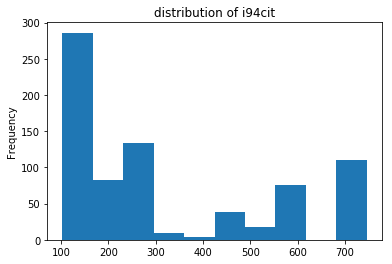

In [14]:
df['i94cit'].plot.hist(title='distribution of i94cit')

In [15]:
df['i94res'].unique()

array([209, 582, 112, 297, 577, 245, 135, 438, 260, 512, 158, 511, 251,
       268, 213, 264, 509, 324, 689, 687, 129, 528, 123, 691, 107, 103,
       130, 694, 368, 575, 276, 116, 514, 124, 273, 692, 117, 131, 579,
       164, 126, 111, 263, 602, 121, 162, 274, 690, 207, 696, 104, 525,
       105, 518, 576, 585, 272, 108, 127, 526, 603, 513, 516, 218, 296,
       204, 464, 140, 258, 201, 114, 257, 520, 206, 243, 261, 586, 115,
       299, 343, 688, 141, 350, 332, 340, 120])

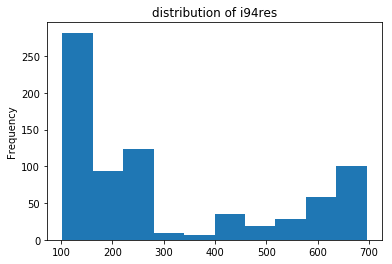

In [16]:
df['i94res'].plot.hist(title='distribution of i94res')

In [17]:
df['i94mode'].unique()

array([1, 2])

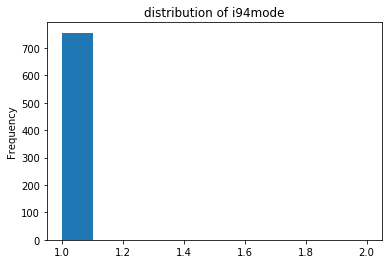

In [18]:
df['i94mode'].plot.hist(title='distribution of i94mode')

In [59]:
df['entdepa'].unique()

array(['G', 'T', 'A', 'K', 'U', 'H', 'P'], dtype=object)

In [61]:
#df['entdepa'].plot.hist()

In [62]:
df['entdepd'].unique()

array(['O', 'R', 'N', 'K', 'D', 'I', 'Q', 'J', 'L'], dtype=object)

In [47]:
df['visatype'].unique()

array(['WT', 'B2', 'B1', 'GMT', 'WB', 'F1', 'E2', 'CP'], dtype=object)

In [24]:
df[['admnum','i94yr','visatype']].groupby(['i94yr','visatype']).count().head() 

admnum
i94yr visatype        
2016  B1            54
      B2           288
      CP             1
      E2             3
      F1             7

Values of visatype (2)
 - B-1 : Visa Holders-Business
 - B-2 : Visa Holders-Pleasure
 - E-1 : Visa Holders-Treaty Trader
 - E-2 : Visa Holders-Treaty Investor
 - F-1 : Visa Holders-Students
 - F-2 : Visa Holders-Family Members of Students
 - GMB : Guam Visa Waiver-Business
 - GMT : Guam Visa Waiver-Tourist
 - I : Visa Holders-Foreign Information Media
 - M-1 : Visa Holders-Vocational Students
 - M-2 : Visa Holders-Family Members of Vocational Students
 - WB : Visa Waiver-Business
 - WT : Visa Waiver-Tourist

In [67]:
df['i94visa'].unique()

array([2, 1, 3])

In [68]:
df[['admnum','i94visa']].groupby('i94visa').count()

,admnum
i94visa,
1,111
2,639
3,7


In [19]:
df_res = df[['admnum','visatype','i94visa']].groupby(['visatype','i94visa']).count()
print(df_res.columns)
df_res

Index(['admnum'], dtype='object')


,,admnum
visatype,i94visa,
B1,1,54
B2,2,288
CP,2,1
E2,1,3
F1,3,7
GMT,2,18
WB,1,54
WT,2,332


In [52]:
test_df = df[['i94visa','visatype']].drop_duplicates()
test_df.head(11)

,i94visa,visatype
0,2,WT
1,2,B2
30,1,B1
35,2,GMT
43,1,WB
70,3,F1
120,1,E2
752,2,CP


Encoded value of <b>i94visa</b> 
 - 1: Business
 - 2: Tourist 
 - 3: Student

In [63]:
df['count'].unique()

array([ 1.])

There is only 1 value for count column.

In [66]:
df[['admnum','count']].groupby('count').count()

,admnum
count,
1.0,757


We can consider dropping count column.

In [21]:
df['depdate'].unique()

array([ 20573.,  20568.,  20571.,  20581.,  20606.,  20635.,  20554.,
        20565.,  20575.,  20560.,  20552.,  20596.,  20567.,  20574.,
        20610.,  20676.,  20569.,  20561.,  20580.,  20562.,  20551.,
        20577.,  20634.,  20570.,  20651.,  20579.,  20553.,  20578.,
        20619.,  20572.,  20564.,  20589.,  20582.,  20639.,  20548.,
        20563.,  20576.,  20605.,  20585.,  20549.,  20557.,  20586.,
        20583.,  20566.,  20626.,  20558.,  20600.,  20555.,  20556.,
        20594.,  20559.,  20623.,  20584.,  20667.,  20550.,  20664.,
        20638.,  20620.,  20715.,  20633.,  20599.,  20591.,  20627.,
        20590.,  20665.,  20661.,  20604.,  20613.,  20624.,  20641.,
        20587.,  20654.,  20609.,  20657.,  20592.,  20603.,  20602.,
        20588.,  20612.,  20611.,  20630.,  20595.,  20660.,  20659.,
        20598.,  20621.,  20593.,  20547.,  20597.,  20693.,  20703.,
        20652.,  20677.,  20647.,  20701.,  20679.,  20645.,  20697.,
        20643.,  206

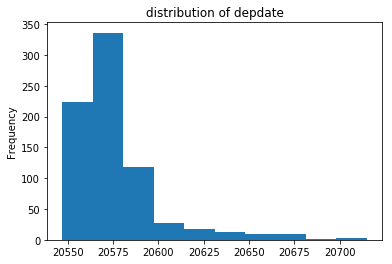

In [23]:
#df[['admnum','depdate']].groupby('depdate').count()
df['depdate'].plot.hist(title='distribution of depdate')

In [70]:
df['dtaddto'].unique()

array(['07202016', '10222016', '07052016', '10272016', '10072016',
       '10112016', '06302016', '07252016', '10252016', '07062016',
       '10052016', '10232016', '10132016', '07152016', '10142016',
       '07012016', '10262016', '07092016', '10292016', '10242016',
       '06112016', '10152016', '10032016', '07272016', '07042016',
       '10102016', '07212016', '07072016', '09302016', '10092016',
       '07132016', '06062016', '07122016', '10162016', '07222016', 'D/S',
       '07112016', '10212016', '10282016', '07262016', '07162016',
       '07282016', '07182016', '10022016', '06152016', '07022016',
       '07142016', '06292016', '10042016', '04082018', '05082016',
       '07172016', '10062016', '07242016', '10202016', '05232016',
       '10192016', '07232016', '07032016', '10182016', '10012016',
       '10122016', '10172016', '05272016', '07102016', '05172016',
       '05152016', '10082016', '07192016', '07082016', '06132016',
       '09012016', '05302016', '04202016', '05162016', 

In [7]:
a_df = df[['arrdate','depdate','dtaddto']]
a_df.head()

,arrdate,depdate,dtaddto
0,20566.0,20573.0,07202016
1,20567.0,20568.0,10222016
2,20551.0,20571.0,07052016
3,20572.0,20581.0,10272016
4,20550.0,20553.0,07042016


In [11]:
#a_df['adate'] = a_df.arrdate + a_df.dtaddto
#a_df['ddate'] = a_df.depdate + a_df.dtaddto
#a_df.head()

In [75]:
f['i94bir'].unique()

array([61, 26, 76, 25, 51, 48, 33,  4, 72, 62, 34, 21, 46, 14, 41, 22, 64,
       17, 42, 35, 16, 40, 27, 56, 32,  8, 59, 38, 43, 10, 52, 19, 31, 58,
       66, 68, 44, 36, 12, 60, 18, 63, 50, 65, 29,  6, 73, 71, 39, 47, 37,
       54, 49, 28, 78, 55, 53, 69, 23, 80, 11, 75, 84, 45, 57, 67, 30,  1,
       77, 70,  5, 24, 15, 83, 20, 13, 81, 93,  3,  9, 87, 74, 85,  2])

In [24]:
test_df = df[['cicid','i94yr','biryear','i94bir']]
test_df['(i94yr-biryear)'] = test_df.i94yr - test_df.biryear 
test_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,cicid,i94yr,biryear,i94bir,(i94yr-biryear)
0,4084316,2016,1955,61,61
1,4422636,2016,1990,26,26
2,1195600,2016,1940,76,76
3,5291768,2016,1991,25,25
5,1481650,2016,1965,51,51


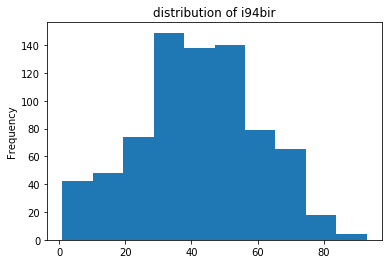

In [25]:
df.i94bir.plot.hist(title='distribution of i94bir')

Immigration data has the following columns;

| Column | Data Type | Description |
|--------|-----------|-------------|
| i94yr   |  .         |     Year of arrival date        |
| i94mon  | . | Month of arrival date |
| i94cit  | . | |
| i94res  | . | | 
| i94port | . | Port of arrival |
| arrdate | . | Arrival date |
| i94mode | . | Mode of transportation(air, land, sea)| 
| i94addr | . | State of stay address|
| depdate | . | Departure date| 
| i94bir  | . | I-94 Age = i94yr-biryear|
| i94visa | . | I-94 Visa (1: Business, 2: Tourist, 3: Student)|
| count   | . | Number of person | 
| dtadfile| . | |
| visapost| . | |
| occup   | . | Occupation? |
| entdepa | . | |
| entdepd | . | |
| entdepu | . | |
| matflag | . | |
| biryear | . | Birth year|
| dtaddto | . | |
| gender  | . | Gender |
| insnum  | . | INS Number |
| airline | . | Airline Code |
| admnum  | . | ADM Number|
| fltno   | . | Flight Number|
| visatype| . | Visa Type|

In [26]:
check_NaN_Values_DF(df,df.columns)

           Column Name  Count Percentage
            Unnamed: 0      0     0.00
                 cicid      0     0.00
                 i94yr      0     0.00
                i94mon      0     0.00
                i94cit      0     0.00
                i94res      0     0.00
               i94port      0     0.00
               arrdate      0     0.00
               i94mode      0     0.00
               i94addr      0     0.00
               depdate      0     0.00
                i94bir      0     0.00
               i94visa      0     0.00
                 count      0     0.00
              dtadfile      0     0.00
               entdepa      0     0.00
               entdepd      0     0.00
               matflag      0     0.00
               biryear      0     0.00
               dtaddto      0     0.00
                gender      0     0.00
               airline      0     0.00
                admnum      0     0.00
                 fltno      0     0.00
              visatype 

Let's look at possible dimension tables

### Visitors

In [27]:
visitors_df = df[['cicid','biryear','gender','i94bir']]
visitors_df.head()

,cicid,biryear,gender,i94bir
0,4084316,1955,F,61
1,4422636,1990,M,26
2,1195600,1940,M,76
3,5291768,1991,M,25
5,1481650,1965,M,51


### Visits

In [28]:
i94_df = df[['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port','i94mode', 'i94addr', 'i94bir','biryear', 'i94visa','visatype']]
i94_df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,i94mode,i94addr,i94bir,biryear,i94visa,visatype
0,4084316,2016,4,209,209,HHW,1,HI,61,1955,2,WT
1,4422636,2016,4,582,582,MCA,1,TX,26,1990,2,B2
2,1195600,2016,4,148,112,OGG,1,FL,76,1940,2,WT
3,5291768,2016,4,297,297,LOS,1,CA,25,1991,2,B2
5,1481650,2016,4,577,577,ATL,1,GA,51,1965,2,B2


In [29]:
i94_df['i94mode'].unique()

array([1, 2])

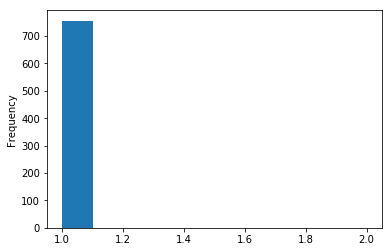

In [30]:
i94_df.i94mode.plot.hist()

In [31]:
print("Value_of_i94mode count")
for v in i94_df['i94mode'].unique():
    print(v,i94_df[ i94_df['i94mode'] == v]['cicid'].count())
    

Value_of_i94mode count
1 756
2 1


In [32]:
print("Top stay desitinations")
test_df = df[['cicid', 'i94addr']]
test_df = test_df.groupby('i94addr').count()
test_df.sort_values(by=['cicid'], ascending=False).head(5)

Top stay desitinations


,cicid
i94addr,
FL,148
NY,139
CA,135
HI,44
NV,32


In [33]:
print("Top stay destinations by age")
test_df = df[['cicid', 'i94bir','i94addr']]
test_df = test_df.groupby(['i94bir','i94addr']).count()
test_df.sort_values(by=['cicid'], ascending=False).head(5)

Top stay destinations by age


,,cicid
i94bir,i94addr,
42,CA,8
50,CA,7
35,NY,7
30,FL,6
44,NY,6


In [36]:
print("Top stay destinations by year and age")
test_df = df[['cicid', 'i94yr','i94bir','i94addr']]
test_df = test_df.groupby(['i94yr','i94bir','i94addr']).count()
test_df.sort_values(by=['cicid'], ascending=False).head(5)

Top stay destinations by year and age


cicid
i94yr i94bir i94addr       
2016  42     CA           8
      50     CA           7
      35     NY           7
      30     FL           6
      44     NY           6

### Flights

In [37]:
df['airline'].unique()

array(['JL', '*GA', 'LH', 'QR', 'DL', 'CX', 'BA', 'QF', 'EK', 'AF', 'OZ',
       'DY', 'UA', 'VS', 'Y4', 'TK', 'AA', 'IB', 'TW', 'AR', 'CA', 'AM',
       'JJ', 'EI', 'NZ', 'CM', 'SU', 'FI', 'AV', 'WN', 'RS', 'KE', 'EV',
       'KL', 'NH', 'AD', 'CI', 'B6', 'BR', 'LX', 'SK', 'EQ', 'SQ', 'AZ',
       '7C', 'LA', '4M', 'SWQ', 'AB', 'NK', 'WK', 'SE', 'AI', 'PY', '4O',
       'HA', 'HU', 'TOM', 'LJ', 'LY', 'VES', 'CZ', 'BB', 'KU', 'MT', 'KX',
       'BW', 'MQ', 'NQ', 'MU', 'EY', 'TP', '9V', 'S3', 'UP', 'JQ', 'AY',
       '2D', 'CP', 'YX', 'PR', 'SV', 'VA', '5J', 'FJ', 'BX', 'UX', '3U',
       'RV', 'LO', 'TB', 'SN', 'WS', '9E', 'W3', 'OS', 'ARU', '7I', 'ZX'], dtype=object)

In [38]:
df[['cicid','airline']].groupby('airline').count().head(5)

,cicid
airline,
*GA,4
2D,2
3U,1
4M,2
4O,3


In [39]:
df['fltno'].unique()

array(['00782', 'XBLNG', '00464', '00739', '910', '870', '00117', '00015',
       '00598', '00215', '00338', '00554', '00143', '00204', '06750',
       '00273', '00872', '00075', '00930', '00033', '01498', '01428',
       '06253', '01085', '00311', '00428', '00196', '01304', '00819',
       '00078', '01504', '00017', '08094', '00139', '06165', '01300', '6',
       '00302', '00102', '00071', '00227', '00876', '00615', '00010',
       '00150', '00838', '00402', '00030', '02039', '02831', '00066',
       '00420', '00079', '07597', '00342', '00085', '00020', '00283',
       '00988', '00228', '08090', '00023', '00925', '00111', '00287',
       '00956', '00992', '00115', '00625', '05510', '00473', '00034',
       '00621', '01089', '00008', '00007', '08704', '00966', '01306',
       '00006', '00060', '00002', '00022', '00907', '00616', '00209',
       '00550', '00062', '00792', '00179', '00578', '982', '00057',
       '00608', '00787', '00016', '00731', '03106', '02514', '00128',
       '0068

In [40]:
# Drop duplicates and rows with NaN value
flights_df = df[df['i94mode']==1]
flights_df = flights_df[['airline','fltno','i94port','i94yr','i94mon']].drop_duplicates().dropna()
flights_df.head()

,airline,fltno,i94port,i94yr,i94mon
0,JL,00782,HHW,2016,4
1,*GA,XBLNG,MCA,2016,4
2,LH,00464,OGG,2016,4
3,QR,00739,LOS,2016,4
5,DL,910,ATL,2016,4


In [41]:
flights_df.count()

airline    597
fltno      597
i94port    597
i94yr      597
i94mon     597
dtype: int64

In [42]:
df.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,2027561,4084316,2016,4,209,209,HHW,20566.0,1,HI,...,G,O,M,1955,07202016,F,JL,56582674633,00782,WT
1,2171295,4422636,2016,4,582,582,MCA,20567.0,1,TX,...,G,R,M,1990,10222016,M,*GA,94361995930,XBLNG,B2
2,589494,1195600,2016,4,148,112,OGG,20551.0,1,FL,...,G,O,M,1940,07052016,M,LH,55780468433,00464,WT
3,2631158,5291768,2016,4,297,297,LOS,20572.0,1,CA,...,G,O,M,1991,10272016,M,QR,94789696030,00739,B2
5,721257,1481650,2016,4,577,577,ATL,20552.0,1,GA,...,T,N,M,1965,10072016,M,DL,736852585,910,B2


### Airport Codes Data [3]

In [43]:
airport_df = pd.read_csv('airport-codes_csv.csv')

In [44]:
airport_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


Let's look at the column names

In [45]:
airport_df.columns

Index(['ident', 'type', 'name', 'elevation_ft', 'continent', 'iso_country',
       'iso_region', 'municipality', 'gps_code', 'iata_code', 'local_code',
       'coordinates'],
      dtype='object')

Raw data has the following columns;

| Column             | Data Type | Description |
|--------------------|-----------|-------------|
| ident              | string    | Identifier        |
| type               | string    | Type of airport |
| name               | string    | Name of airport |
| elevation_ft       | float     | Elevation (in ft) |
| continent          | string    | Continent of airport |
| iso_country        | string    | Country of airport |
| iso_region         | string    | Region of airport |
| municipality       | string    | Municipality of airport |
| gps_code           | string    | GPS Code of airport |
| iata_code          | string    | IATA Code of airport |
| local_code         | string    | Local Code of airport |
| coordinates        | float, float | Coordinates of airport |

In [46]:
check_NaN_Values_DF(airport_df,airport_df.columns)

           Column Name  Count Percentage
                 ident      0     0.00
                  type      0     0.00
                  name      0     0.00
          elevation_ft   7006    12.72
             continent  27719    50.33
           iso_country    247     0.45
            iso_region      0     0.00
          municipality   5676    10.31
              gps_code  14045    25.50
             iata_code  45886    83.32
            local_code  26389    47.91
           coordinates      0     0.00
Number of total records is 55075.



The following columns can be dropped;
 - iata_code    (83.32%)
 - continent    (50.33%)
 - local_code   (47.91%)
 - gps_code     (25.50%)
 - elevation_ft (12.72%)

Drop a row that has NaN value for any of the following columns;
 - iso_country
 - municipality

In [47]:
airport_df = airport_df[['ident', 'type', 'name', 'iso_country','iso_region','municipality', 'coordinates']]
airport_df = airport_df.drop_duplicates().dropna()
airport_df.head()

,ident,type,name,iso_country,iso_region,municipality,coordinates
0,00A,heliport,Total Rf Heliport,US,US-PA,Bensalem,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,US,US-KS,Leoti,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,US,US-AK,Anchor Point,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,US,US-AL,Harvest,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,US,US-AR,Newport,"-91.254898, 35.6087"


In [48]:
check_NaN_Values_DF(airport_df,airport_df.columns)

           Column Name  Count Percentage
                 ident      0     0.00
                  type      0     0.00
                  name      0     0.00
           iso_country      0     0.00
            iso_region      0     0.00
          municipality      0     0.00
           coordinates      0     0.00
Number of total records is 49254.



In [49]:
airport_df.describe()

,ident,type,name,iso_country,iso_region,municipality,coordinates
count,49254,49254,49254,49254,49254,49254,49254
unique,49254,7,46522,241,2629,27019,49101
top,HTMD,small_airport,Centre Hospitalier Heliport,US,US-TX,Seoul,"129.115255, 37.540345"
freq,1,29929,85,22655,2265,404,50


In [50]:
airport_df.count()

ident           49254
type            49254
name            49254
iso_country     49254
iso_region      49254
municipality    49254
coordinates     49254
dtype: int64

Select US airports

In [51]:
us_airport_df = airport_df[airport_df.iso_country == 'US'] 
#us_airport_df['iso_region'] = us_airport_df['iso_region'].apply(lambda x: x.replace('US-',''))
us_airport_df.head(5)

,ident,type,name,iso_country,iso_region,municipality,coordinates
0,00A,heliport,Total Rf Heliport,US,US-PA,Bensalem,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,US,US-KS,Leoti,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,US,US-AK,Anchor Point,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,US,US-AL,Harvest,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,US,US-AR,Newport,"-91.254898, 35.6087"


Let's remove 'US-' prefix from iso_region

In [52]:
us_airport_df_state = us_airport_df['iso_region'].apply(lambda x: x.replace('US-',''))
us_airport_df_state.head()

0    PA
1    KS
2    AK
3    AL
4    AR
Name: iso_region, dtype: object

In [53]:
print("There are %d US airports." % us_airport_df_state.count())

There are 22655 US airports.


In [54]:
us_airport_df = us_airport_df.drop(columns=['iso_region'])
us_airport_df = pd.concat([us_airport_df,us_airport_df_state], axis=1)
us_airport_df.head()

,ident,type,name,iso_country,municipality,coordinates,iso_region
0,00A,heliport,Total Rf Heliport,US,Bensalem,"-74.93360137939453, 40.07080078125",PA
1,00AA,small_airport,Aero B Ranch Airport,US,Leoti,"-101.473911, 38.704022",KS
2,00AK,small_airport,Lowell Field,US,Anchor Point,"-151.695999146, 59.94919968",AK
3,00AL,small_airport,Epps Airpark,US,Harvest,"-86.77030181884766, 34.86479949951172",AL
4,00AR,closed,Newport Hospital & Clinic Heliport,US,Newport,"-91.254898, 35.6087",AR


In [55]:
us_airport_df['coordinates'].apply(lambda x: x.split(',')).head()

0       [-74.93360137939453,  40.07080078125]
1                   [-101.473911,  38.704022]
2              [-151.695999146,  59.94919968]
3    [-86.77030181884766,  34.86479949951172]
4                      [-91.254898,  35.6087]
Name: coordinates, dtype: object

In [56]:
us_airport_df['coordinates'].apply(lambda x: x.split(',')).get_values()

array([['-74.93360137939453', ' 40.07080078125'],
       ['-101.473911', ' 38.704022'], ['-151.695999146', ' 59.94919968'],
       ..., ['-145.294006348', ' 61.9412002563'],
       ['-110.44400024414062', ' 34.003299713134766'],
       ['-159.994003296', ' 60.9807014465']], dtype=object)

## US Cities Demographics [4]

In [57]:
us_cities_df = pd.read_csv('us-cities-demographics.csv',sep=';')

In [58]:
us_cities_df.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [59]:
print("There are %d entries." % len(us_cities_df) )

There are 2891 entries.


Let's look at columns

In [60]:
us_cities_df.columns

Index(['City', 'State', 'Median Age', 'Male Population', 'Female Population',
       'Total Population', 'Number of Veterans', 'Foreign-born',
       'Average Household Size', 'State Code', 'Race', 'Count'],
      dtype='object')

In [61]:
check_NaN_Values_DF(us_cities_df,us_cities_df.columns)

           Column Name  Count Percentage
                  City      0     0.00
                 State      0     0.00
            Median Age      0     0.00
       Male Population      3     0.10
     Female Population      3     0.10
      Total Population      0     0.00
    Number of Veterans     13     0.45
          Foreign-born     13     0.45
Average Household Size     16     0.55
            State Code      0     0.00
                  Race      0     0.00
                 Count      0     0.00
Number of total records is 2891.



We can drop rows having NaN values while we still have at least more than 98% of data.

In [62]:
us_cities_df = us_cities_df.dropna()
us_cities_df.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [63]:
print("There are %d entries." % len(us_cities_df) )

There are 2875 entries.


Raw data has the following columns;

| Column             | Data Type | Description |
|--------------------|-----------|-------------|
| City               | string    | City        |
| State              | string    | State        |
| Median Age         | float   | Median Age |
| Male Population    | integer | Male Population |
| Female Population   | integer | Female Population |
| Total Population   | integer | Total Population |
| Number of Veterans | integer | Number of Veterans |
| Foreign-born       | integer | Number of foreign-born |
| Average Household Size | float | Average Household Size |
| State Code         | string  | State Code |
| Race               | string  | Race |
| Count              | integer | Count |

## Global Land Temperatures By City [5]

In [64]:

fname = '../../data2/GlobalLandTemperaturesByCity.csv'
temp_df = pd.read_csv(fname)

In [65]:
temp_df.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [66]:
check_NaN_Values_DF(temp_df,temp_df.columns)

           Column Name  Count Percentage
                    dt      0     0.00
    AverageTemperature 364130     4.23
AverageTemperatureUncertainty 364130     4.23
                  City      0     0.00
               Country      0     0.00
              Latitude      0     0.00
             Longitude      0     0.00
Number of total records is 8599212.



In [67]:
print("Number of rows both colums have NaN is %d\n" % len(temp_df[(temp_df.AverageTemperature == None) & (temp_df.AverageTemperatureUncertainty == None)]) )

Number of rows both colums have NaN is 0



It seems that it is safe to drop these rows instead of imputation (fillna). We will have at least 91% of data. 

In [68]:
temp_df = temp_df.dropna()
check_NaN_Values_DF(temp_df,temp_df.columns)

           Column Name  Count Percentage
                    dt      0     0.00
    AverageTemperature      0     0.00
AverageTemperatureUncertainty      0     0.00
                  City      0     0.00
               Country      0     0.00
              Latitude      0     0.00
             Longitude      0     0.00
Number of total records is 8235082.



In [3]:
	
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

output_data = './star/'

spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()
df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [4]:
#write to parquet
#df_spark.write.mode("overwrite").parquet("sas_data_test")
#df_spark=spark.read.parquet("sas_data_test")

### Step 2: Explore and Assess the Data


#### Explore the Data: US Cities Demographics

In [4]:
df_spark_us_cities = spark.read.csv("./us-cities-demographics.csv", sep = ';', header = True)
logger.debug("Opened %s\n","./us-cities-demographics.csv")
df_spark_us_cities.printSchema()
df_spark_us_cities.show(5)
df_spark_us_cities.describe().show()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|            City|        State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race|Count|
+----------------+-------------+----------+---------------+-----------------+----------------+--

In [5]:
def check_nan_counts(df):
    assert (df != None), "Invalid Value!"
    for c in df.columns:
        print("Number of rows with None %s column is %d" % (c, df.filter( (df[c].isNull()) ).count()) )
    print("There are %d records!" % df.count())

In [6]:
def check_nan_counts2(df):
    assert (df != None), "Invalid Value!"
    len = df.count()
    print("%22s %10s %8s" % ('Column Name','Count', 'Percentage'))
    for c in df.columns:
        cnt = df.filter( (df[c].isNull()) ).count()
        print("%22s %10d %8.2f" % (c, cnt, 100*(cnt/len) ))
    print("\nThere are %d records!\n" % len )

In [7]:
check_nan_counts(df_spark_us_cities)

Number of rows with None City column is 0
Number of rows with None State column is 0
Number of rows with None Median Age column is 0
Number of rows with None Male Population column is 3
Number of rows with None Female Population column is 3
Number of rows with None Total Population column is 0
Number of rows with None Number of Veterans column is 13
Number of rows with None Foreign-born column is 13
Number of rows with None Average Household Size column is 16
Number of rows with None State Code column is 0
Number of rows with None Race column is 0
Number of rows with None Count column is 0
There are 2891 records!


<b>Conclusion</b>: We should apply dropna() to drop rows that has a column with NaN value.

#### Explore the Data: US Airports

In [8]:
# Load CSV file 
df_spark_us_airports = spark.read.csv("./airport-codes_csv.csv", sep = ',', header = True)
logger.info("Opened %s\n","./us-cities-demographics.csv")
df_spark_us_airports.printSchema()
df_spark_us_airports.show(5)

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)

+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|    

In [9]:
check_nan_counts2(df_spark_us_airports)

           Column Name      Count Percentage
                 ident          0     0.00
                  type          0     0.00
                  name          0     0.00
          elevation_ft       7006    12.72
             continent          0     0.00
           iso_country          0     0.00
            iso_region          0     0.00
          municipality       5676    10.31
              gps_code      14045    25.50
             iata_code      45886    83.32
            local_code      26389    47.91
           coordinates          0     0.00

There are 55075 records!



<b>Conclusion</b>: It is beneficial to drop columns (iata_code,local_code,gps_code,elevation_ft) because of their high percentage of null values. Then, apply dropna() to drop rows that has a column with NaN value.

In [10]:
df_spark_us_airports = df_spark_us_airports.select('ident','iso_country','iso_region','municipality',\
                                               'name','type','coordinates')

In [11]:
check_nan_counts2(df_spark_us_airports)

           Column Name      Count Percentage
                 ident          0     0.00
           iso_country          0     0.00
            iso_region          0     0.00
          municipality       5676    10.31
                  name          0     0.00
                  type          0     0.00
           coordinates          0     0.00

There are 55075 records!



<b>Then</b>: Apply dropna() to drop rows that has a column with NaN value.

In [12]:
check_nan_counts2(df_spark_us_airports.dropna())

           Column Name      Count Percentage
                 ident          0     0.00
           iso_country          0     0.00
            iso_region          0     0.00
          municipality          0     0.00
                  name          0     0.00
                  type          0     0.00
           coordinates          0     0.00

There are 49399 records!



In [13]:
df_spark_us_airports.select('iso_country','iso_region','municipality')\
                    .groupby('iso_country')\
                    .count()\
                    .orderBy('count',ascending=False)\
                    .show(10)
#display(df_vis)
#print(df_vis.column)
#sns.barplot(x='iso_country', y='count', data=df_vis.toPandas(),height=6, kind="bar", palette="muted")

+-----------+-----+
|iso_country|count|
+-----------+-----+
|         US|22757|
|         BR| 4334|
|         CA| 2784|
|         AU| 1963|
|         KR| 1376|
|         MX| 1181|
|         RU| 1040|
|         DE|  947|
|         GB|  911|
|         FR|  850|
+-----------+-----+
only showing top 10 rows



#### Explore the Data: Global Land Temperatures By City

In [14]:
df_spark_us_temps = spark.read.csv("../../data2/GlobalLandTemperaturesByCity.csv", header = True)
logger.info("Opened %s\n","../../data2/GlobalLandTemperaturesByCity.csv")
df_spark_us_temps.printSchema()
df_spark_us_temps.show(5)
df_spark_us_temps.describe().show()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)

+----------+------------------+-----------------------------+-----+-------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01|              nu

In [15]:
check_nan_counts2(df_spark_us_temps)

           Column Name      Count Percentage
                    dt          0     0.00
    AverageTemperature     364130     4.23
AverageTemperatureUncertainty     364130     4.23
                  City          0     0.00
               Country          0     0.00
              Latitude          0     0.00
             Longitude          0     0.00

There are 8599212 records!



<b>Conclusion</b>: : Apply dropna() to drop rows that has a column with NaN value.

In [16]:
check_nan_counts2(df_spark_us_temps.dropna())

           Column Name      Count Percentage
                    dt          0     0.00
    AverageTemperature          0     0.00
AverageTemperatureUncertainty          0     0.00
                  City          0     0.00
               Country          0     0.00
              Latitude          0     0.00
             Longitude          0     0.00

There are 8235082 records!



In [17]:
df_spark_us_temps.describe().show()

+-------+----------+--------------------+-----------------------------+--------+-----------+--------+---------+
|summary|        dt|  AverageTemperature|AverageTemperatureUncertainty|    City|    Country|Latitude|Longitude|
+-------+----------+--------------------+-----------------------------+--------+-----------+--------+---------+
|  count|   8599212|             8235082|                      8235082| 8599212|    8599212| 8599212|  8599212|
|   mean|      null|  16.727432636250835|           1.0285747414536532|    null|       null|    null|     null|
| stddev|      null|  10.353442482534422|           1.1297332887133706|    null|       null|    null|     null|
|    min|1743-11-01|-0.00099999999999...|                        0.034|A Coruña|Afghanistan|   0.80N|    0.00W|
|    max|2013-09-01|               9.999|                        9.998|  Ürümqi|   Zimbabwe|   8.84S|   99.91E|
+-------+----------+--------------------+-----------------------------+--------+-----------+--------+---

#### Explore the Data: US Visitors Data

In [18]:
check_nan_counts2(df_spark)

           Column Name      Count Percentage
                 cicid          0     0.00
                 i94yr          0     0.00
                i94mon          0     0.00
                i94cit          0     0.00
                i94res          0     0.00
               i94port          0     0.00
               arrdate          0     0.00
               i94mode        239     0.01
               i94addr     152592     4.93
               depdate     142457     4.60
                i94bir        802     0.03
               i94visa          0     0.00
                 count          0     0.00
              dtadfile          1     0.00
              visapost    1881250    60.76
                 occup    3088187    99.74
               entdepa        238     0.01
               entdepd     138429     4.47
               entdepu    3095921    99.99
               matflag     138429     4.47
               biryear        802     0.03
               dtaddto        477     0.02
         

<b>Conclusion</b>: It is beneficial to drop columns (occup,entdepu,insnum,visapost) because of their high percentage of null values. Then, apply dropna() to drop rows that has a column with NaN value.

In [19]:
df_spark = df_spark.drop('occup','entdepu','insnum','visapost')
check_nan_counts2(df_spark.dropna())

           Column Name      Count Percentage
                 cicid          0     0.00
                 i94yr          0     0.00
                i94mon          0     0.00
                i94cit          0     0.00
                i94res          0     0.00
               i94port          0     0.00
               arrdate          0     0.00
               i94mode          0     0.00
               i94addr          0     0.00
               depdate          0     0.00
                i94bir          0     0.00
               i94visa          0     0.00
                 count          0     0.00
              dtadfile          0     0.00
               entdepa          0     0.00
               entdepd          0     0.00
               matflag          0     0.00
               biryear          0     0.00
               dtaddto          0     0.00
                gender          0     0.00
               airline          0     0.00
                admnum          0     0.00
         

In [20]:
df_spark.dropna().describe('i94yr').show()

+-------+-------+
|summary|  i94yr|
+-------+-------+
|  count|2384498|
|   mean| 2016.0|
| stddev|    0.0|
|    min| 2016.0|
|    max| 2016.0|
+-------+-------+



#### Cleaning Steps: Summary

| Data Set                                | Recommendations |
|-----------------------------------------|-----------------|
| <b>US Cities Demographics</b>           | Apply dropna() |
| <b>US Airports</b>                      | Drop columns (iata_code,local_code,gps_code,elevation_ft)<br>Apply dropna() |
| <b>Global Land Temperatures By City</b> | Apply dropna() |
| <b>US I94 Immigration Data</b>          | Drop columns (occup,entdepu,insnum,visapost)<br>Apply dropna()             |

In [91]:
#df_spark.head(5)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model



The proposed design uses [star schema](https://en.wikipedia.org/wiki/Star_schema) to support many different queries. The following [Parquet files](https://parquet.apache.org/) are for dimensional tables;

 - <b>us_cities.parquet</b> keeps track of US Cities and demographics.
 - <b>us_airports.parquet</b> keeps track of US Airports.
 - <b>flights.parquet</b> keeps track of flights.
 - <b>visitors.parquet</b> keeps track of visitors.

![](./img/image.png)

<i>us_cities.parquet</i> has the following columns;

| Column             | Data Type | Description |
|--------------------|-----------|-------------|
| state              | string    | State        |
| state_code         | string    | State Code |
| city               | string    | City        |
| population_total   | integer   | Total Population |
| population_male    | integer   | Male Population |
| population_female  | integer   | Female Population |
| veterans_cnt       | integer   | Number of Veterans |
| foreign_born_cnt   | integer   | Number of foreign-born |
| median_age         | float     | Median Age |
| ave_household_size | float     | Average Household Size |

<i>us_airports.parquet</i> has the following columns;

| Column             | Data Type | Description |
|--------------------|-----------|-------------|
| id                 | string    | Identifier        |
| iso_region         | string    | Region of airport |
| iso_country        | string    | Country of airport |
| municipality       | string    | Municipality of airport |
| name               | string    | Name of airport |
| type               | string    | Type of airport |
| coordinates        | float, float | Coordinates of airport |

<i>flights.parquet</i> has the following columns;

| Column       | Data Type | Description |
|--------------|-----------|-------------|
| id           | integer   | Unique Identifier | 
| airline      | string    | Airline Code | 
| flight_no    | string    | Flight Number |
| airport_code | string    | Airport Code |
| date_yy      | integer   | Year of Date of Flight |
| date_mm      | Integer   | Month of Data of Flight |

<i>visitors.parquet</i> has the following columns;

| Column | Data Type | Description |
|--------|-----------|-------------|
| id     | string    | Visitor Identifier           |
| dob_yy | integer   | Year of DOB |
| gender | string    | Gender |
| age    | integer   | Age at visit |

<i>visits.parquet</i> is a fact table and has the following columns;


| Column         | Data Type | Description |
|----------------|-----------|-------------|
| id             | integer   | Identifier        |
| visit_yy       | integer   |     Year of arrival date        |
| visit_mm       | integer   | Month of arrival date |
| cit_code       | integer   | |
| res_code       | integer   | | 
| port_code      | string    | Port of arrival |
| transport_mode | string    | Mode of transportation(air, land, sea)| 
| visitor_id     | integer   | (FK) Visitor's identifier (=> visitors)|
| flight_id      | string    | (FK) Flight's identifier (=> flights)|
| addr_state     | string    | State of stay address |
| visa_kind      | integer   | I-94 Visa (1: Business, 2: Tourist, 3: Student)|
| visa_type      | string    | Visa Type|

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

 1. Ingest US Cities data
   - select US cities
   - Load US cities
 1. Ingest US Airports from Airports Data
   - Select US Airports
   - Load airports
     * Link to a record in US cities
 1. Ingest US Visitors data 
   - Select visits by Air 
   - Extract and load flights
   - Extract and load visitors
   - Extract and load visits
     * Link to a record in flights
     * Link to a record in vsitors

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [21]:
#
# Utilities
#
def log_df(df,          # type : Spark DataFrame
           table_name   # type : string, table name
          ):
    if df is None:
        raise ValueError('DataFrame is None!')
    print('\nTable: %s\n' % table_name)
    df.printSchema()
    df.show(5)

In [22]:
#
# Extracts records for us_cities.parquet
#
def extract_us_cities(df               # type : Spark DataFrame
                     ):
    """ Extracts US Cities """
    if df is None:
        raise ValueError('DataFrame is None!')

    # Rename Columns to be consistent with documentation
    df_spark_us_cities = df.withColumnRenamed('Median Age','median_age')
    df_spark_us_cities = df_spark_us_cities.withColumnRenamed('City','city')
    df_spark_us_cities = df_spark_us_cities.withColumnRenamed('State','state')
    df_spark_us_cities = df_spark_us_cities.withColumnRenamed('Male Population','population_male')
    df_spark_us_cities = df_spark_us_cities.withColumnRenamed('Female Population','population_female')
    df_spark_us_cities = df_spark_us_cities.withColumnRenamed('Total Population','population_total')
    df_spark_us_cities = df_spark_us_cities.withColumnRenamed('Number of Veterans','veterans_cnt')
    df_spark_us_cities = df_spark_us_cities.withColumnRenamed('Foreign-born','foreign_born_cnt')
    df_spark_us_cities = df_spark_us_cities.withColumnRenamed('Average Household Size','ave_household_size')
    df_spark_us_cities = df_spark_us_cities.withColumnRenamed('State Code','state_code')

    # Select Columns since we do not need all
    df_spark_us_cities = df_spark_us_cities.select('state','state_code','city','population_total',\
                                               'population_male','population_female','veterans_cnt',\
                                               'foreign_born_cnt','ave_household_size')
    # Revise data type of columns - astype/cast
    df_spark_us_cities = df_spark_us_cities.withColumn('population_total',df_spark_us_cities['population_total'].cast('integer'))
    df_spark_us_cities = df_spark_us_cities.withColumn('population_female',df_spark_us_cities['population_female'].cast('integer'))
    df_spark_us_cities = df_spark_us_cities.withColumn('population_male',df_spark_us_cities['population_male'].cast('integer'))
    df_spark_us_cities = df_spark_us_cities.withColumn('veterans_cnt',df_spark_us_cities['veterans_cnt'].cast('integer'))
    df_spark_us_cities = df_spark_us_cities.withColumn('foreign_born_cnt',df_spark_us_cities['foreign_born_cnt'].cast('integer'))
    df_spark_us_cities = df_spark_us_cities.withColumn('ave_household_size',df_spark_us_cities['ave_household_size'].cast('float'))
    
    # Clean rows having NaN values
    return df_spark_us_cities.dropna()


In [23]:
#
# Loads records to us_cities.parquet
#
def load_us_cities(df,               # type : Spark DataFrame
                      output_data_path, # type : String, directoty of parquet file
                      output_data_name, # type : String, name of parquet file
                      output_data_mode  # type : String, mode (overwrite, append) for parquet file 
                     ):
    """ Loads US Cities """
    if df is None:
        raise ValueError('DataFrame is None!')

    # Write 
    df.write.mode(output_data_mode).partitionBy("state").parquet(output_data_path + output_data_name)

    return df


In [24]:
#
# write us_cities.parquet
#
def process_us_cities(df,               # type : Spark DataFrame
                      output_data_path, # type : String, directoty of parquet file
                      output_data_name, # type : String, name of parquet file
                      output_data_mode  # type : String, mode (overwrite, append) for parquet file 
                     ):
    """ Extracts and Loads US Cities """
    if df is None:
        raise ValueError('DataFrame is None!')

    # Extract records
    df_spark_us_cities = extract_us_cities(df)

    # Load records 
    return load_us_cities(df_spark_us_cities,output_data_path,output_data_name,output_data_mode)


In [25]:
# Read CSV File 
df_spark_us_cities = spark.read.csv("./us-cities-demographics.csv", sep = ';', header = True)
log_df(df_spark_us_cities,'us_cities.parquet')

# Load values to us_cities.parquet
df_spark_us_cities = process_us_cities(df_spark_us_cities,output_data,'us_cities.parquet','overwrite')

# Log 
log_df(df_spark_us_cities,'us_cities.parquet')


Table: us_cities.parquet

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|            City|        State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race|Count|
+----------------+-------------+----------+---------------+----------

Load US Airports data. 

In [26]:
#
# Extracts US Airports for us_airports table from Spark DataFrame (df)
#
def extract_us_airports(df               # type : Spark DataFrame
                       ):
    """ Extracts US Airports """
    
    if df is None:
        raise ValueError('DataFrame is None!')

    # Rename Columns
    df_spark_us_airports = df.withColumnRenamed('ident','id')
    df_spark_us_airports = df_spark_us_airports.withColumnRenamed('iso_region','iso_region_0')


    # Extract State Code from iso_region column, for US, prefixed with 'US-'
    df_spark_us_airports = df_spark_us_airports.withColumn('iso_region',regexp_replace('iso_region_0', "US-", ""))

    # Drop iso_region_0 column and clean rows having NaN value
    df_spark_us_airports = df_spark_us_airports.drop('iso_region_0').dropna()

    # Select Columns
    return df_spark_us_airports.select('id','iso_country','iso_region','municipality',\
                                               'name','type','coordinates')


In [27]:
#
# Loads US Airports to us_airports table from Spark DataFrame (df)
#
def load_us_airports(df,               # type : Spark DataFrame
                        output_data_path, # type : String, directoty of parquet file
                        output_data_name, # type : String, name of parquet file
                        output_data_mode  # type : String, mode (overwrite, append) for parquet file 
                       ):
    """ Loads US Airports """
    
    if df is None:
        raise ValueError('DataFrame is None!')

    # Write to dimension table
    df.write.mode(output_data_mode) \
            .partitionBy('iso_country','iso_region','municipality') \
            .parquet(output_data_path + output_data_name)
    # Return 
    return df


In [28]:
#
# Extracts and loads US Airports to us_airports table from Spark DataFrame (df) 
#
def process_us_airports(df,               # type : Spark DataFrame
                        output_data_path, # type : String, directoty of parquet file
                        output_data_name, # type : String, name of parquet file
                        output_data_mode  # type : String, mode (overwrite, append) for parquet file 
                       ):
    """ Extracts and loads US Airports """
    
    if df is None:
        raise ValueError('DataFrame is None!')

    # Extract
    df_spark_us_airports = extract_us_airports(df)
    
    # Load & Return 
    return load_us_airports(df_spark_us_airports,output_data_path,output_data_name,output_data_mode)


In [29]:
# Load CSV file 
df_spark_us_airports = spark.read.csv("./airport-codes_csv.csv", sep = ',', header = True)
log_df(df_spark_us_airports,'us_airports.parquet')

# Select Airports in US
df_spark_us_airports = df_spark_us_airports.filter(df_spark_us_airports.iso_country=='US')

# Load airports data to us_airports.parquet
df_spark_us_airports = process_us_airports(df_spark_us_airports,output_data,'us_airports.parquet','overwrite')

# Log
log_df(df_spark_us_airports,'us_airports.parquet')



Table: us_airports.parquet

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)

+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     helip

In [30]:
#
# Extracts records for flights table from Spark DataFrame (df)
#
def extract_us_flights(df               # type : Spark DataFrame
                      ):
    """ Extract US flights """
    
    if df is None:
        raise ValueError('DataFrame is None!')

    # Select columns
    df_spark_flights = df.select('airline','fltno','i94port','i94yr','i94mon')

    df_spark_flights = df_spark_flights.withColumnRenamed('fltno','flight_no')
    df_spark_flights = df_spark_flights.withColumnRenamed('i94yr','date_yy')
    df_spark_flights = df_spark_flights.withColumnRenamed('i94mon','date_mm')
    df_spark_flights = df_spark_flights.withColumnRenamed('i94port','airport_code')
    df_spark_flights = df_spark_flights.withColumn('id', monotonically_increasing_id())
    
    # Revise data type of columns - astype/cast
    df_spark_flights = df_spark_flights.withColumn('date_yy',df_spark_flights['date_yy'].cast('integer'))
    df_spark_flights = df_spark_flights.withColumn('date_mm',df_spark_flights['date_mm'].cast('integer'))

    # Drop duplicate rows (distinct()) and rows having NaN value and return
    return df_spark_flights.dropDuplicates(['airline','flight_no','date_yy','date_mm','airport_code']).dropna()


In [31]:
#
# Loads data to flights Table
#
def load_us_flights(df,               # type : Spark DataFrame
                       output_data_path, # type : String, directoty of parquet file
                       output_data_name, # type : String, name of parquet file
                       output_data_mode  # type : String, mode (overwrite, append) for parquet file 
                      ):
    """ Extract and load flights """
    
    if df is None:
        raise ValueError('DataFrame is None!')

    # Write to dimension table
    df.write.mode(output_data_mode) \
                    .partitionBy('date_yy','date_mm','airport_code','airline') \
                    .parquet(output_data_path + output_data_name)
    # return
    return df


In [32]:
#
# flights Table
#
def process_us_flights(df,               # type : Spark DataFrame
                       output_data_path, # type : String, directoty of parquet file
                       output_data_name, # type : String, name of parquet file
                       output_data_mode  # type : String, mode (overwrite, append) for parquet file 
                      ):
    """ Extract and load flights """
    
    if df is None:
        raise ValueError('DataFrame is None!')

    # Extract 
    df_spark_flights = extract_us_flights(df)

    # Write to dimension table and return
    return load_us_flights(df_spark_flights,output_data_path,output_data_name,output_data_mode)


In [33]:
# Select Inbound Air Arrivals
df_spark_flights = df_spark.filter(df_spark.i94mode==1).limit(1000)

# Load records to flights.parquet
df_spark_flights = process_us_flights(df_spark_flights, output_data, 'flights.parquet', "overwrite")
    
# Log
log_df(df_spark_flights,'flights.parquet')



Table: flights.parquet

root
 |-- airline: string (nullable = true)
 |-- flight_no: string (nullable = true)
 |-- airport_code: string (nullable = true)
 |-- date_yy: integer (nullable = true)
 |-- date_mm: integer (nullable = true)
 |-- id: long (nullable = false)

+-------+---------+------------+-------+-------+---+
|airline|flight_no|airport_code|date_yy|date_mm| id|
+-------+---------+------------+-------+-------+---+
|     OS|       93|         WAS|   2016|      4|  1|
|     AA|    00199|         NYC|   2016|      4|  2|
|     AZ|    00602|         NYC|   2016|      4|  4|
|     AZ|    00608|         NYC|   2016|      4|  8|
|     TK|    00001|         NYC|   2016|      4|  9|
+-------+---------+------------+-------+-------+---+
only showing top 5 rows



In [34]:
df_join = df_spark_flights.join(df_spark_us_airports, df_spark_flights.airport_code == df_spark_us_airports.id)
df_join.show()

+-------+---------+------------+-------+-------+---+---+-----------+----------+------------+----+----+-----------+
|airline|flight_no|airport_code|date_yy|date_mm| id| id|iso_country|iso_region|municipality|name|type|coordinates|
+-------+---------+------------+-------+-------+---+---+-----------+----------+------------+----+----+-----------+
+-------+---------+------------+-------+-------+---+---+-----------+----------+------------+----+----+-----------+



In [35]:
#
# Extract records for visitors table from Spark DataFrame (df)
#
def extract_visitors(df               # type : Spark DataFrame
                    ):
    """ Extract Visitors data """
    
    if df is None:
        raise ValueError('DataFrame is None!')

    # Select/project columns
    df_spark_visitors = df.select('cicid','biryear','gender','i94bir')

    df_spark_visitors = df_spark_visitors.withColumnRenamed('cicid','id')
    df_spark_visitors = df_spark_visitors.withColumnRenamed('biryear','dob_yy')
    df_spark_visitors = df_spark_visitors.withColumnRenamed('i94bir','age')

    # Revise data type of columns - astype/cast
    df_spark_visitors = df_spark_visitors.withColumn('id',df_spark_visitors['id'].cast('integer'))
    df_spark_visitors = df_spark_visitors.withColumn('dob_yy',df_spark_visitors['dob_yy'].cast('integer'))

    # Drop duplicate rows (distinct()) and rows having NaN value, then return 
    return df_spark_visitors.distinct().dropna()


In [40]:
#
# Loads data to visitors table from Spark DataFrame (df)
#
def load_visitors(df,               # type : Spark DataFrame
                     output_data_path, # type : String, directoty of parquet file
                     output_data_name, # type : String, name of parquet file
                     output_data_mode  # type : Strinf, mode (overwrite, append) for parquet file
                    ):
    """ Load Visitors data """
    
    if df is None:
        raise ValueError('DataFrame is None!')

    # Write to dimension table 
    df.write.mode(output_data_mode) \
            .partitionBy('dob_yy','gender') \
            .parquet(output_data_path +  output_data_name)
    
    # Returns the handle of dataframe
    return df


In [41]:
#
# visitors table
#
def process_visitors(df,               # type : Spark DataFrame
                     output_data_path, # type : String, directoty of parquet file
                     output_data_name, # type : String, name of parquet file
                     output_data_mode  # type : Strinf, mode (overwrite, append) for parquet file
                    ):
    """ Extract and Load Visitors data """
    
    if df is None:
        raise ValueError('DataFrame is None!')

    # Extract Visitors 
    df_spark_visitors = extract_visitors(df)

    # Load Visitors and return the handle of dataframe
    return load_visitors(df_spark_visitors, output_data_path, output_data_name, output_data_mode)


In [42]:

# Select Visitors via Air Arrivals
df_spark_visitors = df_spark.filter(df_spark.i94mode==1)

# Load records to visitors.parquet
df_spark_visitors = process_visitors(df_spark_visitors,output_data,'visitors.parquet','overwrite')

# Log
log_df(df_spark_visitors, 'visitors.parquet')



Table: visitors.parquet

root
 |-- id: integer (nullable = true)
 |-- dob_yy: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)

+----+------+------+----+
|  id|dob_yy|gender| age|
+----+------+------+----+
| 898|  2003|     M|13.0|
| 927|  1968|     M|48.0|
|2406|  1989|     F|27.0|
|2520|  1940|     F|76.0|
|2600|  1973|     F|43.0|
+----+------+------+----+
only showing top 5 rows



In [38]:
# visits Table
#from pyspark.sql.functions import col, expr, when
from pyspark.sql.types import StringType

def process_visits(df,               # type : Spark DataFrame
                   output_data_path, # type : String, directoty of parquet file
                   output_data_name, # type : String, name of parquet file
                   output_data_mode  # type : String, mode (overwrite, append) for parquet file
                  ):
    """ Extract and Load Visits """
    # Check
    if df is None:
        raise ValueError('df is None!')
        
    # Select/project columns
    df_spark_visits = df.select('cicid','i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port',\
                                         'i94addr', 'i94visa','visatype','id')

    df_spark_visits = df_spark_visits.withColumnRenamed('id','flight_id')
    df_spark_visits = df_spark_visits.withColumnRenamed('i94yr','visit_yy')
    df_spark_visits = df_spark_visits.withColumnRenamed('i94mon','visit_mm')
    df_spark_visits = df_spark_visits.withColumnRenamed('i94cit','cit_code')
    df_spark_visits = df_spark_visits.withColumnRenamed('i94res','res_code')
    df_spark_visits = df_spark_visits.withColumnRenamed('i94port','port_code')
    df_spark_visits = df_spark_visits.withColumnRenamed('i94addr','stay_state')
    df_spark_visits = df_spark_visits.withColumnRenamed('i94visa','visa_kind')
    df_spark_visits = df_spark_visits.withColumnRenamed('visatype','visa_type')
    df_spark_visits = df_spark_visits.withColumnRenamed('cicid','id')
    
    # Revise data type of columns - astype/cast
    df_spark_visits = df_spark_visits.withColumn('id',df_spark_visits['id'].cast('integer'))
    df_spark_visits = df_spark_visits.withColumn('visit_yy',df_spark_visits['visit_yy'].cast('integer'))
    df_spark_visits = df_spark_visits.withColumn('visit_mm',df_spark_visits['visit_mm'].cast('integer'))
    df_spark_visits = df_spark_visits.withColumn('cit_code',df_spark_visits['cit_code'].cast('integer'))
    df_spark_visits = df_spark_visits.withColumn('res_code',df_spark_visits['res_code'].cast('integer'))
    df_spark_visits = df_spark_visits.withColumn('visa_kind',df_spark_visits['visa_kind'].cast('integer'))
    
    # (FK) visitor_id
    df_spark_visits = df_spark_visits.withColumn('visitor_id',df_spark_visits['id'])

    # Drop rows having NaN value in any column
    df_spark_visits = df_spark_visits.dropna()

    # Write to dimension table
    df_spark_visits.write \
                .mode(output_data_mode) \
                .partitionBy('port_code','visit_yy','visit_mm') \
                .parquet(output_data_path + output_data_name)
    # Return
    return df_spark_visits


In [41]:
# Select Visits via Air Arrivals
df_spark_visits = df_spark.filter(df_spark.i94mode==1)

# (FK) flight_id  
df_spark_visits = df_spark_visits.join(df_spark_flights, (df_spark_flights.airline == df_spark_visits.airline) & \
                                                        (df_spark_flights.flight_no ==  df_spark_visits.fltno) & \
                                                       (df_spark_flights.airport_code == df_spark_visits.i94port) & \
                                                       (df_spark_flights.date_yy == df_spark_visits.i94yr) & \
                                                       (df_spark_flights.date_mm == df_spark_visits.i94mon)  )  
# Load records to visits.parquet
df_spark_visits = process_visits(df_spark_visits,output_data, 'visits.parquet', "overwrite")

# Log
log_df(df_spark_visits, 'visits.parquet')



Table: visits.parquet

root
 |-- id: integer (nullable = true)
 |-- visit_yy: integer (nullable = true)
 |-- visit_mm: integer (nullable = true)
 |-- cit_code: integer (nullable = true)
 |-- res_code: integer (nullable = true)
 |-- port_code: string (nullable = true)
 |-- stay_state: string (nullable = true)
 |-- visa_kind: integer (nullable = true)
 |-- visa_type: string (nullable = true)
 |-- flight_id: long (nullable = false)
 |-- visitor_id: integer (nullable = true)

+---+--------+--------+--------+--------+---------+----------+---------+---------+---------+----------+
| id|visit_yy|visit_mm|cit_code|res_code|port_code|stay_state|visa_kind|visa_type|flight_id|visitor_id|
+---+--------+--------+--------+--------+---------+----------+---------+---------+---------+----------+
| 15|    2016|       4|     101|     101|      WAS|        MI|        2|       B2|        1|        15|
| 16|    2016|       4|     101|     101|      NYC|        MA|        2|       B2|        2|        16|
| 

In [42]:
df_join = df_spark_visits.join(df_spark_visitors, df_spark_visits.visitor_id == df_spark_visitors.id)
df_join.show()

+-----+--------+--------+--------+--------+---------+----------+---------+---------+---------+----------+-----+------+------+----+
|   id|visit_yy|visit_mm|cit_code|res_code|port_code|stay_state|visa_kind|visa_type|flight_id|visitor_id|   id|dob_yy|gender| age|
+-----+--------+--------+--------+--------+---------+----------+---------+---------+---------+----------+-----+------+------+----+
|  148|    2016|       4|     103|     103|      NEW|        NY|        2|       WT|       81|       148|  148|  1995|     F|21.0|
|  833|    2016|       4|     104|     104|      BOS|        NY|        2|       WT|      694|       833|  833|  2000|     F|16.0|
| 1088|    2016|       4|     104|     104|      NEW|        NY|        2|       WT|      776|      1088| 1088|  1973|     F|43.0|
| 1238|    2016|       4|     104|     104|      NYC|        FL|        2|       WT|      165|      1238| 1238|  2006|     M|10.0|
| 1580|    2016|       4|     104|     104|      LOS|        CA|        2|       WT

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [1]:
# Perform quality checks here

def check_row_count_equals(df,           # type, Sprk DataFrame, Data
                           column_name,  # type, String, Column Name
                           table_name    # type, String, Name of table
                          ):
    """ Compares the number of rows with the number of unique values in column"""
    if df is None:
        raise ValeError('df dataframe is invalid!')
    if column_name is None:
        raise ValeError('column_name is invalid!')
    if table_name is None:
        raise ValeError('table_name is invalid!')
        
    cnt_id = df.select(column_name).distinct().count()
    cnt_rows = df.count()
    if cnt_id == cnt_rows:
        print("Counts of rows and counts of unique %s matched for %s" % (column_name,table_name))
    else:
        print("Counts of rows and counts of unique %s DID NOT matched for %s" % (column_name,table_name))
    return


In [134]:
check_row_count_equals(df_spark_visits,'id','visits')

Counts of rows and counts of unique id matched for visits


In [135]:
check_row_count_equals(df_spark_flights,'id','flights')

Counts of rows and counts of unique id matched for flights


In [136]:
check_row_count_equals(df_spark_visitors,'id','visitors')

Counts of rows and counts of unique id matched for visitors


In [137]:
if df_spark_visits.count() == df_spark_visitors.count():
    print("Counts of rows matched for %s and %s" % ('visits','visitors'))
else:
    print("Counts of rows DID NOT matched for %s and %s" % ('visits','visitors'))


Counts of rows DID NOT matched for visits and visitors


#### 4.3 Data dictionary 
<i>
Create a data dictionary for your data model. 
For each field, provide a brief description of what the data is and where it came from. 
You can include the data dictionary in the notebook or in a separate file.</i>

Source and description of <i>us_cities.parquet</i> columns;

| Column             | Description            | Source                                        |
|--------------------|------------------------|-----------------------------------------------|
| state              | State                  | us-cities-demographics/State                  |
| state_code         | State Code             | us-cities-demographics/State Code             |
| city               | City                   | us-cities-demographics/City                   |
| population_total   | Total Population       | us-cities-demographics/Total Population       |
| population_male    | Male Population        | us-cities-demographics/Male Population        |
| population_female  | Female Population      | us-cities-demographics/Female Population      |
| veterans_cnt       | Number of Veterans     | us-cities-demographics/Number of Veterans     |
| foreign_born_cnt   | Number of foreign-born | us-cities-demographics/Foreign-born           |
| median_age         | Median Age             | us-cities-demographics/Median Age             |
| ave_household_size | Average Household Size | us-cities-demographics/Average Household Size |

Source and description of <i>us_airports.parquet</i> columns;

| Column       | Description             | Source                      |
|--------------|-------------------------|-----------------------------|
| id           | Identifier              | airport-codes/ident         |
| iso_region   | Region of airport       | airport-codes/iso_region    |
| iso_country  | Country of airport      | airport-codes/iso_country   |
| municipality | Municipality of airport | airport-codes/municipality  |
| name         | Name of airport         | airport-codes/name          |
| type         | Type of airport         | airport-codes/type          |
| coordinates  | Coordinates of airport  | airport-codes/coordinates   |

Source and description of <i>flights.parquet</i> columns;

| Column       | Description             | Source                  |
|--------------|-------------------------|-------------------------|
| airline      | Airline Code            | immigration_data/airline |
| flight_no    | Flight Number           | immigration_data/fltno   |
| airport_code | Airport Code            | immigration_data/i94port |
| date_yy      | Year of Date of Flight  | immigration_data/i94yr   |
| date_mm      | Month of Data of Flight | immigration_data/i94mon  |

Source and description of <i>visitors.parquet</i> columns;

| Column | Description        | Source |
|--------|--------------------|--------|
| id     | Visitor Identifier | immigration_data/cicid       |
| dob_yy | Year of DOB        | immigration_data/i94bir       |
| gender | Gender             | immigration_data/Gender       |
| age    | Age at visit       | immigration_data/biryear       |

Source and description of <i>visits.parquet</i> columns;


| Column         | Description                                    | Source |
|----------------|------------------------------------------------|-----------------------|
| id             | Identifier                                     | immigration_data/cicid |
| visit_yy       | Year of arrival date                           | immigration_data/i94yr     |
| visit_mm       | Month of arrival date                          | immigration_data/i94mon |
| cit_code       | .                                              | immigration_data/i94cit |
| res_code       | .                                              | immigration_data/i94res |
| port_code      | Port of arrival                                | immigration_data/i94port  |
| transport_mode | Mode of transportation(air, land, sea)         | immigration_data/i94mode  |
| visitor_id     | (FK) Visitor's identifier (=> visitors)        | visitors.parquet/id  |
| flight_id      | (FK) Flight's identifier (=> flights)          | flights.parquet/id  |
| addr_state     | State of stay address                          | us_cities.parquet/state_code  |
| visa_kind      | I-94 Visa (1: Business, 2: Tourist, 3: Student)| immigration_data/i94visa  | 
| visa_type      | Visa Type                                      | immigration_data/visatype  |


For each month, what are the main reason (business, tourism, education) of visits? 

In [138]:
df_spark_visits.select('visit_mm','visa_kind')\
                .groupby('visit_mm','visa_kind')\
                .count()\
                .orderBy("count",ascending=False)\
                .show()

+--------+---------+-------+
|visit_mm|visa_kind|  count|
+--------+---------+-------+
|       4|        2|2340519|
|       4|        1| 497840|
|       4|        3|  38736|
+--------+---------+-------+



Which states are top-10 destinations for Tourists?

In [139]:
df_spark_visits.filter(df_spark_visits.visa_kind==2)\
                .select('visit_mm','stay_state')\
                .groupby('visit_mm','stay_state')\
                .count()\
                .orderBy("count",ascending=False)\
                .show(10)

+--------+----------+------+
|visit_mm|stay_state| count|
+--------+----------+------+
|       4|        FL|565225|
|       4|        NY|475608|
|       4|        CA|363005|
|       4|        HI|159259|
|       4|        GU| 93007|
|       4|        NV| 92019|
|       4|        TX| 88639|
|       4|        NJ| 60688|
|       4|        IL| 51854|
|       4|        MA| 45740|
+--------+----------+------+
only showing top 10 rows



Which states are top-10 destinations for Business travelers?

In [140]:
df_spark_visits.filter(df_spark_visits.visa_kind==1)\
                .select('visit_mm','stay_state')\
                .groupby('visit_mm','stay_state')\
                .count()\
                .orderBy("count",ascending=False)\
                .show(10)

+--------+----------+-----+
|visit_mm|stay_state|count|
+--------+----------+-----+
|       4|        CA|90523|
|       4|        NY|60699|
|       4|        FL|47702|
|       4|        TX|40509|
|       4|        IL|27678|
|       4|        NV|21978|
|       4|        MA|19792|
|       4|        WA|15811|
|       4|        GA|14981|
|       4|        MI|14329|
+--------+----------+-----+
only showing top 10 rows



In [45]:
df_q = df_spark_visits.join(df_spark_visitors, df_spark_visits.visitor_id==df_spark_visitors.id).select('visit_mm','stay_state','age')
df_v = df_q.groupby('visit_mm','stay_state','age')\
        .count()\
        .orderBy("count",ascending=False)
df_v.show(10)


+--------+----------+----+-----+
|visit_mm|stay_state| age|count|
+--------+----------+----+-----+
|       4|        NY|30.0| 2465|
|       4|        NY|50.0| 2307|
|       4|        NY|31.0| 2242|
|       4|        NY|29.0| 2179|
|       4|        NY|40.0| 2121|
|       4|        NY|28.0| 2113|
|       4|        NY|33.0| 2042|
|       4|        NY|32.0| 2042|
|       4|        NY|27.0| 1990|
|       4|        NY|44.0| 1948|
+--------+----------+----+-----+
only showing top 10 rows



In [43]:
df_q = df_spark_visits.join(df_spark_flights, df_spark_visits.flight_id==df_spark_flights.id).select('visit_mm','airline')
df_q.groupby('visit_mm','airline')\
        .count()\
        .orderBy("count",ascending=False)\
        .show(10)

+--------+-------+-----+
|visit_mm|airline|count|
+--------+-------+-----+
|       4|     LH|84379|
|       4|     AA|45981|
|       4|     BA|43742|
|       4|     DL|34766|
|       4|     AF|33641|
|       4|     UA|30151|
|       4|     KL|20016|
|       4|     TK|15842|
|       4|     SK|12040|
|       4|     LX| 9617|
+--------+-------+-----+
only showing top 10 rows



In [44]:
df_q.select('airline').groupby('airline')\
        .count()\
        .orderBy("count",ascending=False)\
        .show(10)

+-------+-----+
|airline|count|
+-------+-----+
|     LH|84379|
|     AA|45981|
|     BA|43742|
|     DL|34766|
|     AF|33641|
|     UA|30151|
|     KL|20016|
|     TK|15842|
|     SK|12040|
|     LX| 9617|
+-------+-----+
only showing top 10 rows



#### Step 5: Complete Project Write Up


* <b>Clearly state the rationale for the choice of tools and technologies for the project.</b> <br>
The rationale to use star schema is to support anticipated and ununticipated queries. 

* <b>Propose how often the data should be updated and why.</b> <br>
The visits, visitors, and flights tables should be updated with hourly data because US Visits data comes every hour and every day (due to constant arrival of visitors to US ports). This data flow will keep appending new records to flights and visitors tables. 
If each US airport can push their hourly US Visits data to AWS S3 or GCS bucket, then an Airflow DAG can extract data from AWS S3 or GCS bucket and load received data to flights, visitors, and visits table in AWS Redshift. <p>
<br>
Because the cities and airports are very slowly changing dimensions, it is better to handle insertion of a record via GUI. 

* <b>Write a description of how you would approach the problem differently under the following scenarios:</b>
 * <b>The data was increased by 100x.</b><br>
 Will use Airflow with Spark operator to ingest data paralel. 

* <b>Write a description of how you would approach the problem differently under the following scenarios:</b>
 * <b>The data populates a dashboard that must be updated on a daily basis by 7am every day.</b><br>
 Depending on data needs of dashboard, a data mart tables will be automatically prepared before 7am every day by using Airflow because we can have scheduled scripts.

* <b>Write a description of how you would approach the problem differently under the following scenarios:</b>
 * <b>The database needed to be accessed by 100+ people.</b><br>
    <p>
    Assuming that we know the queries then we can use NoSQL solutions (Cassandra) because the above scenario suggests a read heavy system. 
    NoSQL solution will remove cost of join operations, and partioned data can improve the query execution time and concurrency. 

## References
 1. https://travel.trade.gov/research/programs/i94/description.asp
 1. https://travel.trade.gov/research/programs/i94/methodology.asp
 1. Airport Codes, https://datahub.io/core/airport-codes#readme
 1. US Cities: Demographics, https://public.opendatasoft.com/explore/dataset/us-cities-demographics/table/
 1. Climate Change: Earth Surface Temperature Data, https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
 